In [1]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
using DiffEqCallbacks
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using ProgressBars
using NonlinearSolve
using BenchmarkTools
using Libdl

In [2]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb, threshold_du, threshold_std, t_std, f_counter)
    list_t, popup_t, nbr_error_t, sol_t = [], [], [], []
    sol_ss, time_ss = [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
        
        # Load the functions
        fsolve(du, u, p, t) = functions[f_counter](du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)



        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (0, t_end))
        
        println("$i, $chunk")

        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                    reltol=1.0e-5,
                    abstol=1.0e-5,
                    dtmin = 1e-2)

        push!(list_t, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])
        push!(sol_t, sol.u)

        if ~SciMLBase.successful_retcode(sol) # If solution DV, add it to the error
            push!(nbr_error_t, i)
        end
    end
    return list_t, popup_t, nbr_error_t, sol_t
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

load_f

### Define the system

In [3]:
# Nbr of particles
N_list = [2:2:10;]
r = 10
 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 100 #2e3 # atoms per unit of volume (already normalized)
d0_lb = 1e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb / λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
t_end = 1e2
threshold_du = 1e-3
threshold_std, t_std = 1e-3, 15; # Time over which the std is computed

### Compute stationnary state for r repetitions

In [4]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [5]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functions[i] = load_f("diffeqf", libpath)
end

In [6]:
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
popup_t_N, list_t_N, sol_ss_N, time_ss_N = [], [], [], []
sol_t_N, nbr_error_t_N = [], []

for (i, N) in ProgressBar(enumerate(N_list))
    # popup_t, nbr_error_t, list_t, sol_t, sol_ss, time_ss, n_es_t_list, time_n_es, std_es_list, time_std_es_list = [], [], [], [], [], [], [], [], [], []
    @load "op_list/op_list_$N.jdl2" op_list
    tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
        Threads.@spawn solve_random_distrib(chunk, functions, op_list, N, n0, d0_lb, threshold_du, threshold_std, t_std, i)
    end
    sol_tasks = fetch.(tasks)
    push!(list_t_N, vcat([s[1] for s in sol_tasks]...))
    push!(popup_t_N, vcat([s[2] for s in sol_tasks]...))
    push!(nbr_error_t_N, vcat([s[3] for s in sol_tasks]...))
    push!(sol_t_N, vcat([s[4] for s in sol_tasks]...))
end


0.0%┣                                                ┫ 0/5 [00:01<00:-6, -1s/it]


5, 5:6
7, 7:8
1, 1:2
3, 3:4
9, 9:10
8, 7:8
4, 3:4
6, 5:6
10, 9:10
2, 1:2


7, 7:8
3, 3:4
1, 1:2
5, 5:6
9, 9:10
6, 5:6
4, 3:4
10, 9:10
2, 1:2
8, 7:8
7, 7:8
3, 3:4
1, 1:2
9, 9:10
5, 5:6
8, 7:8
6, 5:6
2, 1:2


20.0%┣████████▋                                  ┫ 1/5 [00:10<Inf:Inf, InfGs/it]


4, 3:4
10, 9:10
7, 7:8
3, 3:4
5, 5:6
1, 1:2
9, 9:10


60.0%┣████████████████████████████▉                   ┫ 3/5 [00:10<00:10, 5s/it]


6, 5:6
8, 7:8
2, 1:2
10, 9:10


┌ Warning: dt(0.01) <= dtmin(0.01) at t=0.0, and step error estimate = 2577.806078779271. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:653


4, 3:4
7, 7:8
9, 9:10
1, 1:2
3, 3:4
5, 5:6


80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:11<00:04, 4s/it]


4, 3:4


┌ Warning: dt(0.01) <= dtmin(0.01) at t=0.013917271111980415, and step error estimate = 0.5982910948044557. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:653


6, 5:6
2, 1:2
8, 7:8
10, 9:10


100.0%┣███████████████████████████████████████████████┫ 5/5 [00:19<00:00, 5s/it]
100.0%┣███████████████████████████████████████████████┫ 5/5 [00:19<00:00, 5s/it]


In [7]:
@save "solutions/sol_N_$(N_list)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N time_ss_N sol_ss_N

In [8]:
# @load "solutions/sol_N_$(N)_r_$(r).jld2" list_t_N popup_t_N nbr_error_t_N sol_t_N time_ss_N sol_ss_N

# Plots with time evolution

In [29]:
fig, ax = subplots()
for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        if j ∉ nbr_error_t_N[i]
            if j == 1
                line, = ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label=N_list[i])
            else
                ax.plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, color=line.get_color())
            end
        end
    end
end

for i in 1:length(time_ss_N)
    for j = 1:length(time_ss_N[i])
        ax.scatter(time_ss_N[i][j], sol_ss_N[i][j], color="red")
    end
end

ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.legend()

suptitle("N = $N_list, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false); gcf();
pygui(true); show()

# Plot the evolutions that didn't work

In [15]:
close("all")
fig, axes = subplots(1, 2, figsize=(10, 5))
for i in 1:length(popup_t_N)
    for j in 1:length(popup_t_N[i])
        @load "r0/r0_N_$(N_list[i])_r_$j.jdl2" r0 L
        if j ∈ nbr_error_t_N[i]
            axes[1].plot(list_t_N[i][j], popup_t_N[i][j], marker="o", markersize=1, label="N=$(N_list[i]), r=$j")
            axes[2].scatter(N_list[i], min_r0(r0), color ="r")
        else
            axes[2].scatter(N_list[i], min_r0(r0), color ="b")
        end

    end
end
axes[2].hlines(d0_lb, N_list[1], N_list[end])
axes[1].set_xlabel(L"$\gamma t$")
axes[1].set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
axes[2].set_xlabel(L"N")
axes[2].set_ylabel(L"min(r_0)")
axes[1].legend()
# pygui(false); gcf();
pygui(true); show()

# Timestep 

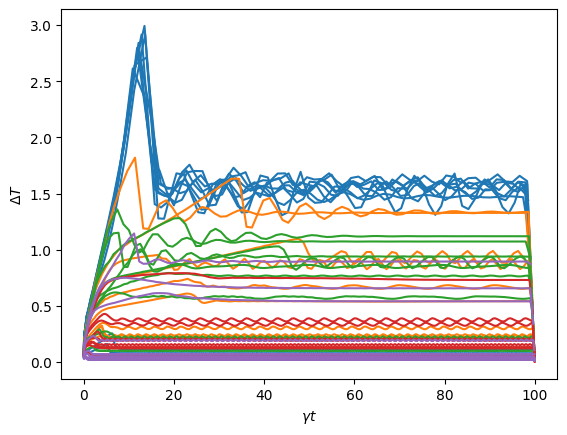

In [11]:
close("all")
fig, ax = subplots()
for i in 1:length(popup_t_N)
    line = []
    for j in 1:length(popup_t_N[i])
        T = list_t_N[i][j]
        counter_ss = 1
        if j == 1
            line, = ax.plot(T[1:end-1], T[2:end]-T[1:end-1], label=N_list[i])
        else
            ax.plot(T[1:end-1], T[2:end]-T[1:end-1], color=line.get_color())
        end

    end
end

ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\Delta T$")
pygui(false); gcf();
# pygui(true); show()

# Find problematic distribution

In [ ]:
fig, ax = subplots()
i=9

line, = ax.plot(list_t[i], popup_t[i], marker="o", markersize=1)
# ax.scatter(time_ss[i], sol_ss[i], color="red")


ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf();
# pygui(true); show()